# Planet Candidate detected in TESS sample data

The candidate was simply detected by after after eye-ball inspection of sample data (see tess_inspect bulk data.ipynb). 

The next problem is to get stellar parameters (i.e. for limb-darkening priors) from CTL (See tess_CTL.ipynb). However, the list is bulky (1.7 Gb) so a better query scheme should be implemented.

Reference:
* [ETE-6 TESS Simulated Data Products](http://archive.stsci.edu/tess/ete-6.html)
* 

## TIC 347504686

In [43]:
ticID= 347505194

In [1]:
base='https://archive.stsci.edu/missions/tess/ete-6/tid/00/'
name='000/003/475/tess2019128220341-0000000347505194-0016-s_lc.fits'

sample=base+name

In [2]:
from astropy.io import fits

hdr =fits.getheader(sample)
data=fits.getdata(sample)

In [3]:
hdr['OBJECT']

'TIC 347505194'

data._coldefs.names

## get lightcurve

In [4]:
import pandas as pd
from astropy.table import Table

tab = Table.read(sample, format='fits')
df = tab.to_pandas()

In [5]:
#df = df.dropna()
df.head()

,TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
0,1612.845248,0.004536,101,41160.898438,22.264729,1212.712646,3.984494,45784.417969,25.113028,0,436.644781,0.000382,1643.486979,0.000389,436.509393,0.000382,1643.379017,0.000421,0.060713,0.021951
1,1612.846637,0.004536,102,41132.722656,22.256916,1209.716431,3.980983,45763.390625,25.104218,0,436.624276,0.000384,1643.487471,0.000389,436.491271,0.000382,1643.379092,0.000421,0.040648,0.021230
2,1612.848026,0.004536,103,41141.125000,22.259237,1210.542480,3.979418,45780.796875,25.106834,0,436.637121,0.000383,1643.487004,0.000389,436.502653,0.000382,1643.378536,0.000421,0.053168,0.020577
3,1612.849415,0.004536,104,41095.726562,22.249323,1214.147949,3.984207,45733.855469,25.095652,0,436.631631,0.000384,1643.486500,0.000390,436.497565,0.000382,1643.378381,0.000422,0.048149,0.020815
4,1612.850804,0.004536,105,41109.890625,22.253094,1211.991333,3.981785,45751.890625,25.099907,0,436.633994,0.000383,1643.486012,0.000390,436.499759,0.000382,1643.377969,0.000422,0.050349,0.020538


In [6]:
df.shape

(20610, 20)

## convenience function

In [7]:
def get_data(data):
    t = data['TIME']
    f = data['SAP_FLUX']
    e = data['SAP_FLUX_ERR']
    b = data['SAP_BKG']

    x1 = data['POS_CORR1']
    x2 = data['POS_CORR2']
    return t,f,e,b,x1,x2

Text(0.5,0,'time')

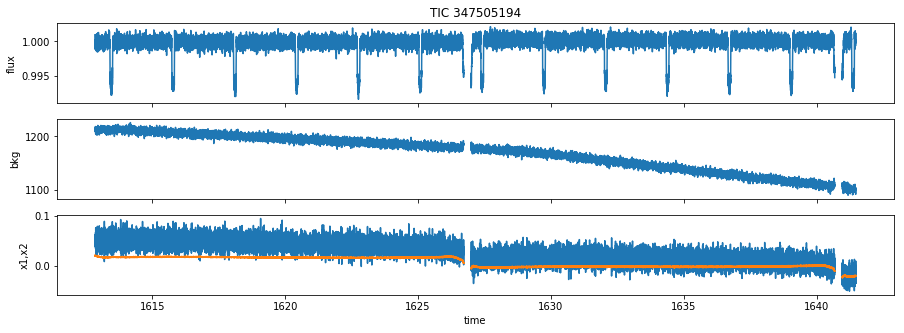

In [8]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

t,f,e,b,x1,x2 = get_data(data)

fig, ax = pl.subplots(3,1,figsize=(15,5), sharex=True)
n=0
ax[n].plot(t,f/np.nanmedian(f))
ax[n].set_title(hdr['OBJECT'])
ax[n].set_ylabel('flux')
n=1
ax[n].plot(t,b)
ax[n].set_ylabel('bkg')
n=2
ax[n].plot(t,x1)
ax[n].plot(t,x2)
ax[n].set_ylabel('x1,x2')

ax[-1].set_xlabel('time')

Remove NaNs. Otherwise, `LombScargleFast` will invoke `assertion error: df > 0`.

In [9]:
df2=df[['TIME','SAP_FLUX','SAP_FLUX_ERR']].dropna()

t,f,e= df2['TIME'], df2['SAP_FLUX'], df2['SAP_FLUX_ERR'] 

f = f/np.nanmedian(f)

t, f, e = np.array(t), np.array(f), np.array(e)

Thinning will enable faster periodogram calculation.

In [10]:
import gatspy
from gatspy.periodic import LombScargleFast # see also LombScargleAstroML

thin = 10
model = LombScargleFast().fit(t[::thin], f[::thin], e[::thin])
periods, power = model.periodogram_auto(nyquist_factor=100)

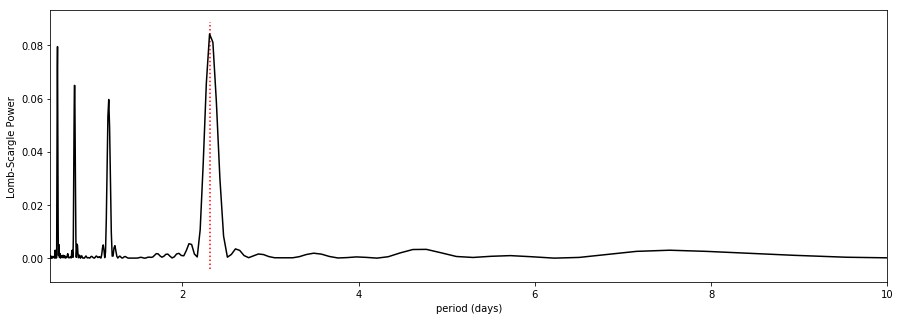

In [11]:
idx1 = periods > 1
idx2 = np.argmax(power[idx1])
peak = periods[idx1][idx2]

fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(periods, power, 'k-')
ax.set(xlim=(0.5, 10),
#         , ylim=(0, 0.01),
   xlabel='period (days)',
   ylabel='Lomb-Scargle Power')
ax.vlines(peak, *ax.get_ylim(), linestyles='dotted', colors='r')

In [12]:
peak

2.3073097898317716

## optimize period search

In [13]:
# set range and find period
model.optimizer.period_range=(2, 3)
peak = model.best_period
print("period = {0}".format(peak))

Finding optimal frequency:
 - Estimated peak width = 0.22
 - Using 5 steps per peak; omega_step = 0.0439
 - User-specified period range:  2 to 3
 - Computing periods at 25 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
period = 2.320243187496826


Check phase

Text(0.5,0,'phase')

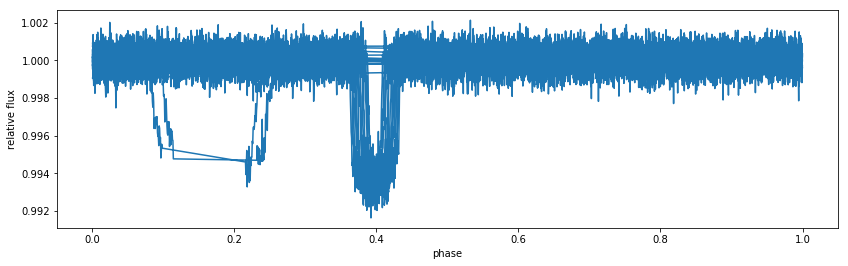

In [14]:
phase = (t/peak) % 1

fig, ax = pl.subplots(1,1,figsize=(14,4), sharex=True)

pl.plot(phase,f)
pl.ylabel('relative flux')
pl.xlabel('phase')

In [15]:
def get_mask(time, t0, period, dur=0.2):
    '''
    Mask all of the transits/eclipses of a given planet/EB. 
    
    :param float t0: The time of first transit (same units as light curve)
    :param float period: The period of the planet in days
    :param foat dur: The transit duration in days. Default 0.2
    
    '''
    mask = []
    t0 += np.ceil((time[0] - dur - t0) / period) * period
    for t in np.arange(t0, time[-1] + dur, period):
        mask.extend(np.where(np.abs(time - t) < dur / 2.)[0])
        
    return mask

def apply_mask(time, mask):
    return np.delete(time, mask, axis=0)

## period1

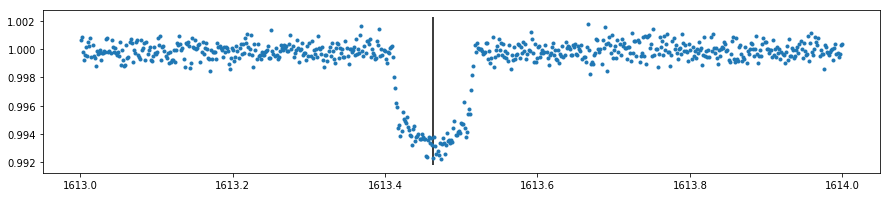

In [16]:
idx = (1613 < t) & (t < 1614)
tsub, fsub = t[idx], f[idx]
idx = fsub < np.median(fsub) - 0.5 * np.std(fsub)
t0 = np.median(tsub[idx])

fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(tsub, fsub, '.')
ax.vlines(t0, *ax.get_ylim())

In [17]:
#import simfit
#tf, ff = simfit.util.fold(t, f, peak, t0)

def get_tns(t, p, t0):

    idx = t != 0
    t = t[idx]

    while t0-p > t.min():
        t0 -= p
    if t0 < t.min():
        t0 += p

    tns = [t0+p*i for i in range(int((t.max()-t0)/p+1))]

    while tns[-1] > t.max():
        tns.pop()

    while tns[0] < t.min():
        tns = tns[1:]

    return tns


def fold(t, f, p, t0, width=0.4, clip=False, bl=False, t14=0.2):
    tns = get_tns(t, p, t0)
    tf, ff = np.empty(0), np.empty(0)
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        ti = t[idx]-tn
        fi = f[idx]
        fi /= np.nanmedian(fi)
        if bl:
            idx = (ti < -t14/2.) | (ti > t14/2.)
            assert np.isfinite(ti[idx]).all() & np.isfinite(fi[idx]).all()
            assert idx.sum() > 0
            try:
                res = sm.RLM(fi[idx], sm.add_constant(ti[idx])).fit()
                if np.abs(res.params[1]) > 1e-2:
                    print('bad data probably causing poor fit')
                    print('transit {} baseline params: {}'.format(i, res.params))
                    continue
                model = res.params[0] + res.params[1] * ti
                fi = fi - model + 1
            except:
                print("error computing baseline for transit {}".format(i))
                print("num. points: {}".format(idx.sum()))
                print(ti)
        tf = np.append(tf, ti)
        ff = np.append(ff, fi / np.nanmedian(fi))
    idx = np.argsort(tf)
    tf = tf[idx]
    ff = ff[idx]
    if clip:
        fc = sigma_clip(ff, sigma_lower=10, sigma_upper=2)
        tf, ff = tf[~fc.mask], ff[~fc.mask]
    return tf, ff

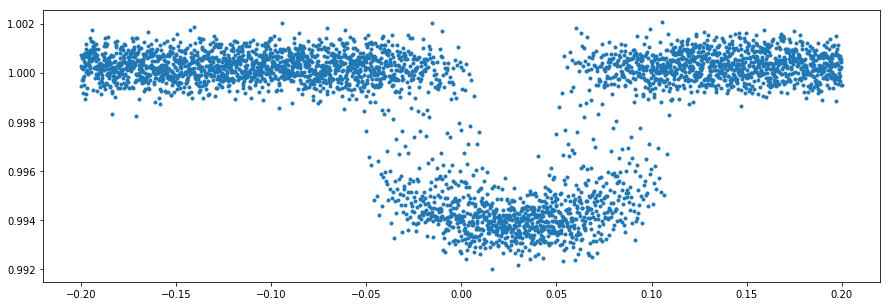

In [18]:
tf, ff = fold(t, f, peak, t0)

fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(tf, ff, '.')

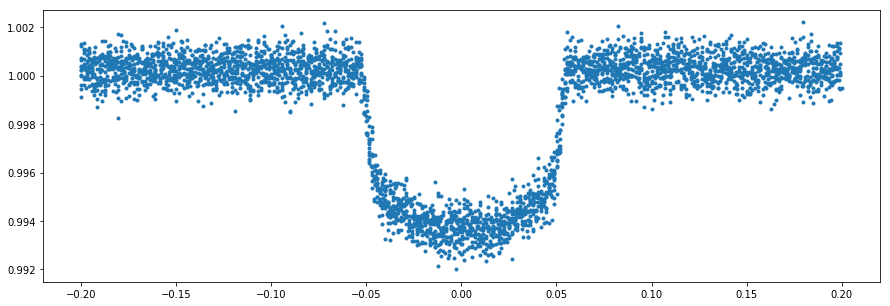

In [19]:
tf, ff = fold(t, f, peak+0.0047, t0)

fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(tf, ff, '.')

## stellar parameters

See also [tess_CTL.ipynb](http://localhost:8891/notebooks/transit/tess_CTL.ipynb)

In [44]:
fileloc='/home/jp/data/transit/tess/ctl/'

with open(fileloc+'header.txt') as f:
    hdr=f.read()
    
cols = hdr.split(',')

import pandas as pd

df = pd.read_csv(fileloc+'00-02.csv')#,low_memory=False)
df.columns = cols

/home/jp/miniconda3/envs/astroconda35/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
df.query('TICID == @ticID')

,RA,DEC,TESSMAG,TEFF,PRIORITY,RADIUS,MASS,CONTRATIO,ECLONG,ECLAT,...,TEFF_SRC_FLAG,STARCHAR_FLAG,RADIUS_ERR,MASS_ERR,LOGG,LOGG_ERR,RHO,RHO_ERR,LUM,LUM_ERR


In [20]:
from pytransit import MandelAgol

MA = MandelAgol()


def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q

    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u

    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2


def model(theta, t, sys=False):
    
    k,t0,p,a,b,q1,q2,_ = theta
    u1,u2 = q_to_u(q1,q2)
    inc   = np.cos(b/a)
    model = MA.evaluate(t, k, (u1,u2), t0, p, a, inc)
    
    return model


def baseline(theta, t):
    ti = t - t.mean()
    c0,c1,c2,c3 = theta[-4:]
    return c0 + c1 * ti + c2 * ti**2 + c3 * ti**3
    
    
def lnlike(theta, t, f):
    
    k,t0,p,a,b,q1,q2,sig = theta
    m = model(theta, t)
    resid = f - m
    inv_sigma2 = 1.0/(sig**2)

    return -0.5*(np.sum((resid)**2*inv_sigma2 - np.log(inv_sigma2)))


def lnprob(theta, t, f):
    #prior
    k,t0,p,a,b,q1,q2,_ = theta
    
    inc = np.cos(b/a)
    if inc > np.pi/2.:
        return -np.inf
    
    #unifrom prior on k
    if k>np.sqrt(1-0.992) or k<np.sqrt(1-0.994):
        return -np.inf
    #unifrom prior on t0
    if t0<1613 or t0>1614:
        return -np.inf
    #unifrom prior on period
    if p<2.324 or p>2.325:
        return -np.inf
    
    if np.any(theta[:-4] < 0):
        return -np.inf
    
    #loglike
    ll = lnlike(theta, t, f)
    return ll if np.isfinite(ll) else -np.inf

nlp = lambda *args: -lnprob(*args)

def scaled_a(p, t14, k, i=np.pi/2.):
    numer = np.sqrt( (k + 1) ** 2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

In [21]:
p = peak+0.0047
t14 = 0.1
k = np.sqrt(1-0.993)
b = 0.1
inc = np.pi/2.
a = scaled_a(p, t14, k, inc)
q1, q2 = 0.2, 0.2
sig = f.std()
lna = 1e-1
lntau = 1
initial = [k,t0,p,a,b,q1,q2,sig]
args = (t, f)

import scipy.optimize as op

opt = op.minimize(nlp, initial, args=args, method='nelder-mead')
print(opt.success)
print(opt.x)

True
[8.36759475e-02 1.61350051e+03 2.32489649e+00 8.04492173e+00
 1.00011543e-01 2.00001462e-01 1.99983077e-01 1.43984257e-03]


In [22]:
param_names = ['${}$'.format(i) for i in r'k,t_0,P,a,b,q_1,q_2,\sigma'.split(',')]

In [23]:
np.c_[param_names,initial,opt.x]

array([['$k$', '0.0836660026534076', '0.08367594750075617'],
       ['$t_0$', '1613.4633008853657', '1613.5005067137606'],
       ['$P$', '2.3249431874968263', '2.3248964925579143'],
       ['$a$', '8.044153527836862', '8.044921728972128'],
       ['$b$', '0.1', '0.10001154312560423'],
       ['$q_1$', '0.2', '0.20000146184606693'],
       ['$q_2$', '0.2', '0.19998307700859655'],
       ['$\\sigma$', '0.0014154991367831826', '0.0014398425737758343']],
      dtype='<U32')

In [24]:
len(initial)

8

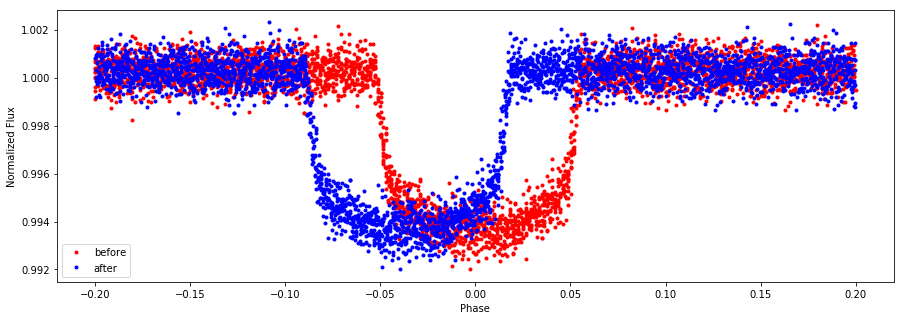

In [25]:
t0_, p_ = opt.x[1], opt.x[2]

tf, ff = fold(t, f, p, t0)
tf_, ff_ = fold(t, f, p_, t0_)

fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(tf, ff, 'r.',label='before')
ax.plot(tf_, ff_, 'b.',label='after')
pl.xlabel('Phase')
pl.ylabel('Normalized Flux')
pl.legend()

In [31]:
from emcee import EnsembleSampler
from emcee.utils import sample_ball

# initial = opt.x

from tqdm import tqdm

ndim = len(initial)
nwalkers = 20 * ndim

nsteps1 = 500
nsteps2 = 3000

sampler = EnsembleSampler(nwalkers, ndim, lnprob, args=args, threads=1)
pos0 = sample_ball(initial, [1e-1]*ndim, nwalkers)

for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

500it [00:02, 207.23it/s]


In [32]:
for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps2)):
    pass

3000it [00:19, 150.61it/s]


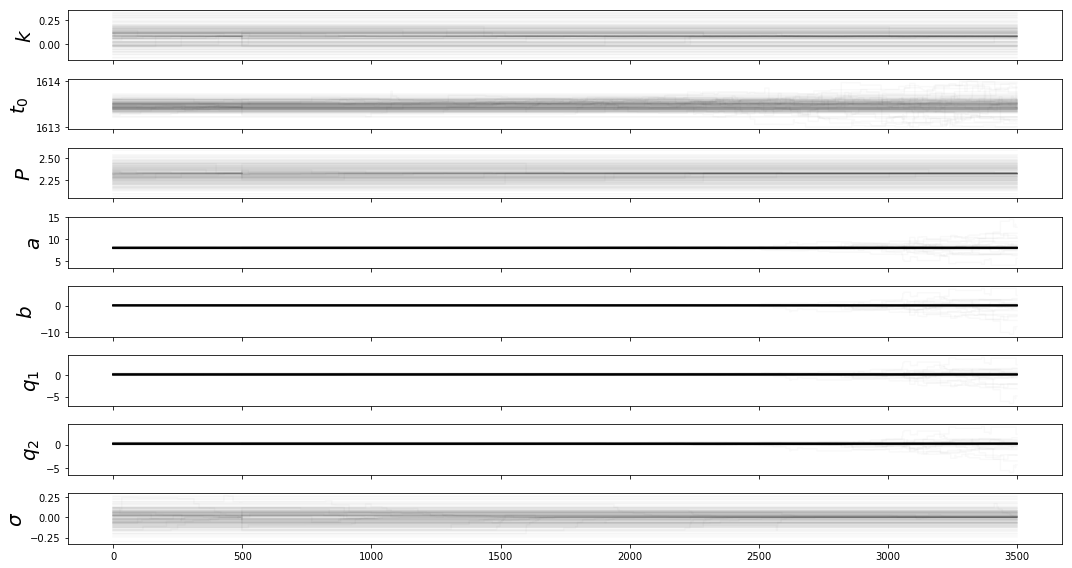

In [33]:
chain = sampler.chain

fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim), sharex=True)
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
for i,ax in enumerate(axs):
    ax.set_ylabel(param_names[i], fontsize=20)
fig.tight_layout()

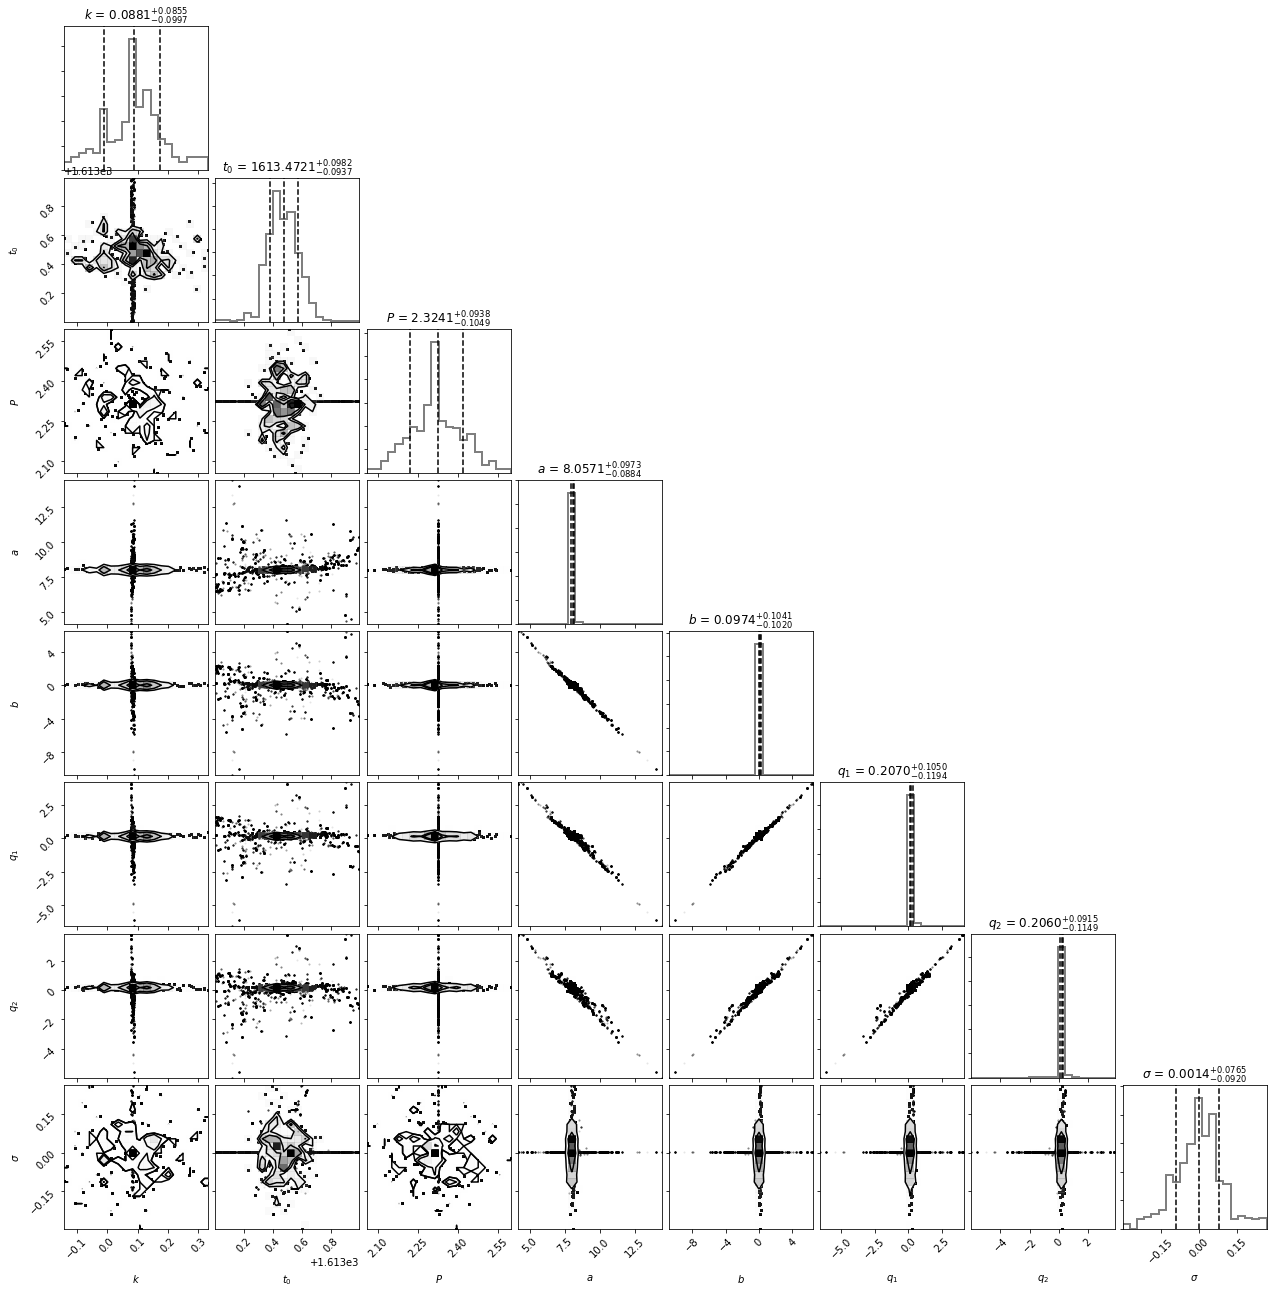

In [35]:
import corner
burn = 1
thin = 1
fc = chain[:,burn::thin,:].reshape(-1, ndim)
hist_kwargs = dict(lw=2, alpha=0.5)
title_kwargs = dict(fontdict=dict(fontsize=12))

corner.corner(fc, 
            labels=param_names,
#             truths=truths,
            hist_kwargs=hist_kwargs,
            title_kwargs=title_kwargs,
            show_titles=True, 
            quantiles=[0.16,0.5,0.84],
            title_fmt='.4f');

In [ ]:
import numpy as np

def compute_w(vecs,y):
    #unpack n-dimensional vector
    X=np.c_[np.atleast_2d(vecs).T]
    try:
        w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, y))
    except:
        #if matrix is singular/ non-invertible
        w=np.linalg.lstsq(X,y, rcond=None)
    return w, X